In [1]:
# add project root (parent of figures) to module search path
import sys, os
sys.path.insert(0, os.path.abspath('/home/reilly/ai_scientist_project'))
# import packages
import numpy as np
import os
import optax
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import inspect
import itertools

# import local modules
import utils, diagnostic, loss_functions, seed_programs, hypothesis_engine

gpu
[CudaDevice(id=0)]


In [ ]:
# neuron_model = seed_programs.neuron_model_2_jax
# parameter_estimator = seed_programs.parameter_estimator_2
# param_names = ['theta_pref', 'baseline', 'amp1', 'amp2', 'width']

In [3]:
# AI MODEL

def neuron_model_numpy(theta,
                    theta_pref_1=0.0,
                    baseline=0.0,
                    amplitude_1=1.0,
                    width_ccw_1=1.0,
                    width_cw_1=1.0,
                    exponent_1=2.0,
                    theta_pref_2=np.pi,
                    amplitude_2=0.0,
                    width_ccw_2=1.0,
                    width_cw_2=1.0,
                    exponent_2=2.0):
    """"
    parent_model_1: VariableExponent_AsymmetricBimodalModel
    parent_model_2: IndependentLocation_AsymmetricPrimaryModel

    Equation:
    Helper Functions:
    _signed_circ_diff_rad(angle, preferred_angle) = arctan2(sin(angle - preferred_angle), cos(angle - preferred_angle))

    Component 1:
    signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1)
    effective_width_1 = width_ccw_1 if signed_diff_1 < 0 else width_cw_1
    component_1 = amplitude_1 * exp(-0.5 * (abs(signed_diff_1) / effective_width_1)**exponent_1)

    Component 2:
    signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2)
    effective_width_2 = width_ccw_2 if signed_diff_2 < 0 else width_cw_2
    component_2 = amplitude_2 * exp(-0.5 * (abs(signed_diff_2) / effective_width_2)**exponent_2)

    Response:
    response = baseline + component_1 + component_2

    This model creates a comprehensive bimodal tuning curve by intelligently combining and enhancing the most effective
    features from its parent models, targeting specific shortcomings observed in the provided neural data.

    Improvements:
    1.  **Unified Peak Shape Flexibility and Asymmetry**: This model brings together the concept of variable exponents
        (`exponent_1`, `exponent_2` from `parent_model_1`) and asymmetric tuning widths for both peaks (`width_ccw_1`, `width_cw_1`, `width_ccw_2`, `width_cw_2`,
        inheriting from `parent_model_1`'s `tuning_width_pos/neg` for both peaks and `parent_model_2`'s `width_left/right` for the primary).
        This provides unparalleled control over the ""peakedness"" (e.g., sharper than Gaussian for high exponents,
        or fatter tails for low exponents to better fit broader shoulders as seen in Cell 91, 169) and the side-to-side
        asymmetry of *both* the primary and secondary response profiles. `parent_model_2` lacked this crucial flexibility for both peaks.

    2.  **Fully Independent Secondary Peak Placement**: Crucially, this model retains `parent_model_2`'s enhancement of allowing the secondary
        preferred direction (`theta_pref_2`) to be fully independent. Unlike `parent_model_1`, which constrained the
        secondary peak to be an offset from the primary's antipodal angle, `theta_pref_2` can be optimized freely. This is vital
        for capturing neurons with complex bimodal tuning where the secondary peak is not strictly 180 degrees from the primary
        (as observed in cells like Cell 1 and Cell 222 in previous models' descriptions, implying non-antipodal secondary peaks).

    3.  **Enhanced Fit Accuracy:** By integrating these powerful and complementary features, this model is designed to
        overcome systematic weaknesses of its predecessors. It provides a more robust framework to capture
        the detailed nuances of neuronal responses, from highly skewed and sharp primary peaks to broad and
        asymmetrically shaped secondary responses that can appear at any angle, thereby leading to a
        significantly lower overall loss.
    """
    # Helper function for signed circular difference, essential for asymmetric tuning
    # Result is in range (-pi, pi]
    def _signed_circ_diff_rad(angle_radians, preferred_angle_radians):
        delta = angle_radians - preferred_angle_radians
        return np.arctan2(np.sin(delta), np.cos(delta))

    # --- Peak 1: Asymmetric, Variable Exponent Gaussian component ---
    signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1)

    # Select width based on the sign of the circular difference (counter-clockwise vs. clockwise)
    width_1_effective = np.where(signed_diff_1 < 0, width_ccw_1, width_cw_1)
    
    # Ensure widths are positive to prevent numerical instability (e.g., division by zero or log of non-positive)
    width_1_effective = np.maximum(width_1_effective, 1e-6) 

    # Calculate the first peak's contribution with variable exponent
    # abs(signed_diff_1) is used because the exponent should operate on the magnitude of the difference.
    peak1_component = amplitude_1 * np.exp(-0.5 * (np.abs(signed_diff_1) / width_1_effective) ** exponent_1)

    # --- Peak 2: Asymmetric, Variable Exponent Gaussian component with independent preferred angle ---
    signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2)

    # Select width based on the sign of the circular difference for the second peak
    width_2_effective = np.where(signed_diff_2 < 0, width_ccw_2, width_cw_2)

    # Ensure widths are positive
    width_2_effective = np.maximum(width_2_effective, 1e-6)

    # Calculate the second peak's contribution with variable exponent
    peak2_component = amplitude_2 * np.exp(-0.5 * (np.abs(signed_diff_2) / width_2_effective) ** exponent_2)

    # Total model response
    return baseline + peak1_component + peak2_component

def neuron_model(theta,
                theta_pref_1=0.0,
                baseline=0.0,
                amplitude_1=1.0,
                width_ccw_1=1.0,
                width_cw_1=1.0,
                exponent_1=2.0,
                theta_pref_2=jnp.pi,
                amplitude_2=0.0,
                width_ccw_2=1.0,
                width_cw_2=1.0,
                exponent_2=2.0):
    
    width_ccw_1, width_cw_1 = jnp.clip(width_ccw_1, 1e-6, None), jnp.clip(width_cw_1, 1e-6, None)
    width_ccw_2, width_cw_2 = jnp.clip(width_ccw_2, 1e-6, None), jnp.clip(width_cw_2, 1e-6, None)
    exponent_1, exponent_2 = jnp.clip(exponent_1, 0.1, 5.0), jnp.clip(exponent_2, 0.1, 5.0)
    
    def _signed_circ_diff_rad(angle_radians, preferred_angle_radians):
        delta = angle_radians - preferred_angle_radians
        return jnp.arctan2(jnp.sin(delta), jnp.cos(delta))

    eps = 1e-12
    signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1) + eps  # Add small epsilon to avoid log(0) issues
    width_1_effective = jnp.where(signed_diff_1 < 0, width_ccw_1, width_cw_1)
    width_1_effective = jnp.maximum(width_1_effective, 1e-6)
    peak1_component = amplitude_1 * jnp.exp(-0.5 * (jnp.abs(signed_diff_1) / width_1_effective) ** exponent_1)

    signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2) + eps  # Add small epsilon to avoid log(0) issues
    width_2_effective = jnp.where(signed_diff_2 < 0, width_ccw_2, width_cw_2)
    width_2_effective = jnp.maximum(width_2_effective, 1e-6)
    peak2_component = amplitude_2 * jnp.exp(-0.5 * (jnp.abs(signed_diff_2) / width_2_effective) ** exponent_2)

    return baseline + peak1_component + peak2_component

def parameter_estimator(stimuli, spike_counts):
    """
    Estimates parameters for the neuron_model_v3 based on stimulus angles and observed spike counts.
    This estimator employs statistical principles to identify and characterize tuning curve peaks,
    including baseline, amplitude, asymmetric widths, preferred directions, and exponents for
    two potential peaks.

    Parameters are estimated directly from a smoothed firing rate curve, aiming for a simple
    yet robust initial estimation suitable for generalized Gaussian-like tuning profiles.

    Parameters:
    stimuli (np.ndarray): An array of stimulus angles in radians (0 to 2*pi).
    spike_counts (np.ndarray): An array of spike counts corresponding to each stimulus.

    Returns:
    np.ndarray: An array containing the estimated parameters in the following order:
                [theta_pref_1, baseline, amplitude_1, width_ccw_1, width_cw_1,
                 exponent_1, theta_pref_2, amplitude_2, width_ccw_2, width_cw_2, exponent_2]
    """
    # --- Configuration Constants ---
    n_bins = 180  # Number of angular bins for tuning curve estimation
    kernel_sigma = 2.5 # Sigma for Gaussian smoothing kernel
    min_peak_amplitude = 0.5 # Min amplitude (spikes/stimulus) above baseline for a peak to be considered valid
    min_model_width = 1e-6 # Minimum allowed width for numerical stability (as per model)
    default_width_value = 1.0 # Default width for non-significant peaks or non-determinable widths
    min_exponent = 0.1 # Minimum allowed exponent value
    max_exponent = 5.0 # Maximum allowed exponent value
    default_exponent_value = 2.0 # Default exponent (Gaussian)
    min_second_peak_ratio = 0.1 # Min amplitude of secondary peak relative to primary
    min_second_peak_separation = np.pi / 4 # Min angular separation between primary and secondary peaks

    # --- 1. Binning and Smoothing ---
    # Convert stimuli to bin indices, handle wrap-around implicitly by modulo in bincount
    bin_idx = ((stimuli * n_bins) / (2 * np.pi)).astype(np.int32)
    bin_idx = np.clip(bin_idx, 0, n_bins - 1)

    sums = np.bincount(bin_idx, weights=spike_counts, minlength=n_bins)
    counts = np.bincount(bin_idx, minlength=n_bins)

    # Create Gaussian smoothing kernel
    kernel_radius = int(3 * kernel_sigma)
    x_kernel = np.arange(-kernel_radius, kernel_radius + 1)
    kernel = np.exp(-0.5 * (x_kernel / kernel_sigma) ** 2)
    kernel /= (np.sum(kernel) + 1e-8) # Normalize kernel

    # Pad arrays for circular convolution
    pad = len(kernel) // 2
    sums_padded = np.pad(sums, (pad, pad), mode='wrap')
    counts_padded = np.pad(counts, (pad, pad), mode='wrap')

    # Convolve to get smoothed sum of spikes and counts
    num_conv = np.convolve(sums_padded, kernel, mode='valid')
    den_conv = np.convolve(counts_padded, kernel, mode='valid')

    # Calculate smoothed tuning curve (avoid division by zero)
    tuning_curve = np.zeros_like(num_conv, dtype=float)
    valid_den_mask = den_conv > 1e-8
    tuning_curve[valid_den_mask] = num_conv[valid_den_mask] / den_conv[valid_den_mask]

    angle_step = 2 * np.pi / n_bins

    # --- 2. Baseline Estimation ---
    # Baseline cannot be negative
    baseline_est = np.maximum(0.0, np.min(tuning_curve))

    # --- Helper function for estimating peak shape parameters ---
    def _get_peak_params_simple(peak_idx_val, peak_idx, bsl, tc, n_bns, ang_step,
                                min_w, def_w, min_exp, max_exp, def_exp, min_amp_thresh):
        amp = peak_idx_val - bsl
        if amp < min_amp_thresh:
            return amp, def_w, def_w, def_exp # Return default parameters if amplitude too small

        # Find bins where tuning curve drops below half-max
        target_half_val = bsl + amp / 2.0
        half_ccw_bins, half_cw_bins = 0, 0
        for k in range(1, n_bns // 2 + 1):
            if half_ccw_bins == 0 and tc[(peak_idx - k + n_bns) % n_bns] <= target_half_val:
                half_ccw_bins = k
            if half_cw_bins == 0 and tc[(peak_idx + k) % n_bns] <= target_half_val:
                half_cw_bins = k
            if half_ccw_bins > 0 and half_cw_bins > 0:
                break
        
        # Calculate width (v1-style, implicitly assuming Gaussian form for width parameter base)
        SQRT_2_LOG_2 = np.sqrt(2 * np.log(2)) 
        width_ccw = (half_ccw_bins * ang_step) / SQRT_2_LOG_2 if half_ccw_bins > 0 else def_w
        width_cw = (half_cw_bins * ang_step) / SQRT_2_LOG_2 if half_cw_bins > 0 else def_w
        
        # Clip widths to valid range
        width_ccw = np.clip(width_ccw, min_w, np.pi)
        width_cw = np.clip(width_cw, min_w, np.pi)

        # Find bins where tuning curve drops below quarter-max for exponent estimation
        target_qtr_val = bsl + amp / 4.0
        qtr_ccw_bins, qtr_cw_bins = 0, 0
        for k in range(1, n_bns // 2 + 1):
            if qtr_ccw_bins == 0 and tc[(peak_idx - k + n_bns) % n_bns] <= target_qtr_val:
                qtr_ccw_bins = k
            if qtr_cw_bins == 0 and tc[(peak_idx + k) % n_bns] <= target_qtr_val:
                qtr_cw_bins = k
            if qtr_ccw_bins > 0 and qtr_cw_bins > 0:
                break
        
        # Exponent estimation (log(2) / log(dist_qtr / dist_half))
        exponent_estimates = []
        if half_ccw_bins > 0 and qtr_ccw_bins > half_ccw_bins: # Ensure ratio > 1 for valid log
            exponent_estimates.append(np.log(2) / np.log(qtr_ccw_bins / half_ccw_bins))
        if half_cw_bins > 0 and qtr_cw_bins > half_cw_bins:
            exponent_estimates.append(np.log(2) / np.log(qtr_cw_bins / half_cw_bins))
        
        # Take mean of valid estimates, else default
        exponent = np.mean(exponent_estimates) if exponent_estimates else def_exp
        exponent = np.clip(exponent, min_exp, max_exp)
        
        return amp, width_ccw, width_cw, exponent

    # --- 3. Peak Identification and Parameter Estimation ---
    # Find all local maxima in the smoothed tuning curve
    local_maxima = []
    for i in range(n_bins):
        prev_val = tuning_curve[(i - 1 + n_bins) % n_bins]
        next_val = tuning_curve[(i + 1) % n_bins]
        if tuning_curve[i] >= prev_val and tuning_curve[i] >= next_val:
            local_maxima.append((tuning_curve[i], i))
    local_maxima.sort(key=lambda x: x[0], reverse=True) # Sort by peak amplitude (descending)

    # Initialize all output parameters with model defaults (if no peak is found)
    theta_pref_1 = 0.0
    amplitude_1 = default_width_value # amplitude for primary peak default to 1 for non-zero contribution if peak is small
    width_ccw_1, width_cw_1, exponent_1 = default_width_value, default_width_value, default_exponent_value
    
    theta_pref_2 = np.pi # Antipodal to default theta_pref_1
    amplitude_2 = 0.0 # Default no second peak
    width_ccw_2, width_cw_2, exponent_2 = default_width_value, default_width_value, default_exponent_value

    # Process Primary Peak
    if local_maxima:
        peak_1_val, peak_1_idx = local_maxima[0]
        # Estimate parameters for the primary (highest) peak
        amplitude_1, width_ccw_1, width_cw_1, exponent_1 = \
            _get_peak_params_simple(peak_1_val, peak_1_idx, baseline_est, tuning_curve, n_bins, angle_step,
                                    min_model_width, default_width_value, min_exponent, max_exponent,
                                    default_exponent_value, min_peak_amplitude)
        theta_pref_1 = peak_1_idx * angle_step
        
        # Process Secondary Peak (if a suitable candidate exists)
        if len(local_maxima) > 1:
            # Iterate through other local maxima to find a suitable secondary peak
            for i in range(1, len(local_maxima)):
                peak_2_val_candidate, peak_2_idx_candidate = local_maxima[i]
                current_amplitude_2_candidate = peak_2_val_candidate - baseline_est
                current_theta_pref_2_candidate = peak_2_idx_candidate * angle_step
                
                # Check amplitude significance relative to primary peak's estimated amplitude
                if current_amplitude_2_candidate < (amplitude_1 * min_second_peak_ratio):
                    continue # Skip if too small compared to the primary peak
                
                # Check angular separation from the *primary* peak
                # np.arctan2(sin(a-b), cos(a-b)) gives circular distance in [-pi, pi]
                peak_sep_rad = np.abs(np.arctan2(np.sin(theta_pref_1 - current_theta_pref_2_candidate),
                                                 np.cos(theta_pref_1 - current_theta_pref_2_candidate)))
                if peak_sep_rad < min_second_peak_separation:
                    continue # Skip if too close to the primary peak

                # Valid secondary peak found, estimate its parameters
                amplitude_2, width_ccw_2, width_cw_2, exponent_2 = \
                    _get_peak_params_simple(peak_2_val_candidate, peak_2_idx_candidate, baseline_est, tuning_curve, n_bins, angle_step,
                                            min_model_width, default_width_value, min_exponent, max_exponent,
                                            default_exponent_value, min_peak_amplitude)
                theta_pref_2 = current_theta_pref_2_candidate
                
                # Break after finding the first suitable secondary peak (highest amplitude among remaining candidates)
                break
    
    # --- Pack and return parameters in the correct order for neuron_model_v3 ---
    return np.array([theta_pref_1, baseline_est, amplitude_1, width_ccw_1, width_cw_1,
                     0.5, theta_pref_2, amplitude_2, width_ccw_2, width_cw_2, 0.5])

param_names = ['theta_pref_1', 'baseline', 'amplitude_1', 'width_ccw_1', 'width_cw_1',
               'exponent_1', 'theta_pref_2', 'amplitude_2', 'width_ccw_2', 'width_cw_2',
               'exponent_2']
default_params = np.array([0.0, 0.0, 1.0, 1.0, 1.0,
                           2.0, np.pi, 0.0, 1.0, 1.0, 2.0])

In [60]:
# To train the model, we only extract the reliable responses ( > 0).
# We can overwrite response and angles with the cropped versions, as we already have R1 and R2
conc_thresh, activity_thresh = 0.5, 0.5 # thresholds for conc and activity
data_dir = '/home/reilly/Downloads/8279387/gratings_drifting_GT1_2019_04_12_1.npy'
# data_dir = '/Users/reillytilbury/Desktop/gratings/gratings_static_GT1_2019_04_17_1.npy'
neural_data = np.load(data_dir, allow_pickle=True)
neural_data = neural_data.item()
response = utils.extract_stimulus_related_response(neural_data, n_pcs=0)
angles = neural_data['istim']
n_trials = response.shape[1]
n_trials_small = int(n_trials * activity_thresh)

# filter 
active = (response > 0).astype(np.float32)
firing_probs = np.mean(active, axis=1)
conc = np.abs(np.sum(np.exp(2j * angles)[np.newaxis, :] * response, axis=1) / np.sum(response, axis=1))
good_cells = np.where((firing_probs > activity_thresh) & (conc > conc_thresh))[0]
n_good_cells = len(good_cells)
conc = conc[good_cells]
firing_probs = firing_probs[good_cells]

# update angles and response to be (n_cells_small, n_trials_small) and (n_cells_small, n_trials_small)
response_cropped, angles_cropped = np.zeros((len(good_cells), n_trials_small)), np.zeros((len(good_cells), n_trials_small))
for i, cell in enumerate(good_cells):
    active_trials = response[cell] > 0
    active_trials_idx = np.where(active_trials)[0][:n_trials_small]
    response_cropped[i] = response[cell, active_trials_idx]
    angles_cropped[i] = angles[active_trials_idx]
    
# update response and angles to be the cropped versions and convert to JAX arrays
response, angles = jnp.asarray(response_cropped), jnp.asarray(angles_cropped)
# normalize response of each cell
response_norms = jnp.linalg.norm(response, axis=1)
response = 100 * response / response_norms[:, None]  # scale to 100
del neural_data

# split good cells into two random subsets of equal size, train_cells and test_cells.
key = jax.random.PRNGKey(420)
training_size = n_good_cells // 2
shuffled_indices = jax.random.permutation(key, jnp.arange(n_good_cells))
training_cells, test_cells = shuffled_indices[:training_size], shuffled_indices[training_size:]
response_train, response_test = response[training_cells, :], response[test_cells, :]
angles_train, angles_test = angles[training_cells, :], angles[test_cells, :]
print(f"Selected {len(good_cells)} cells with activity > {activity_thresh} and concentration > {conc_thresh}.")
print(f"Using {len(training_cells)} cells for training and {len(test_cells)} cells for testing.")

Selected 673 cells with activity > 0.5 and concentration > 0.5.
Using 336 cells for training and 337 cells for testing.


Training on cell 18 of 336 cells.


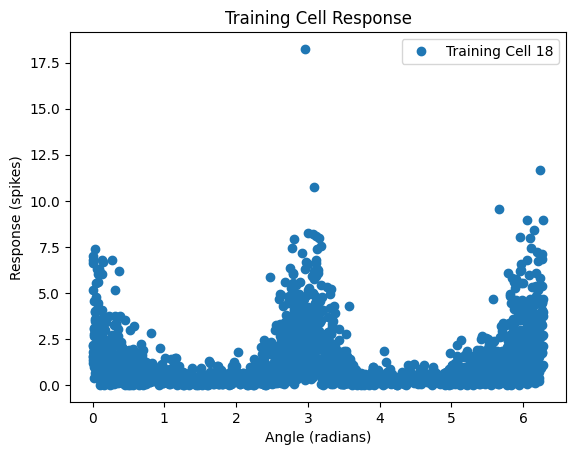

In [61]:
cell_index = np.random.randint(0, len(angles_train))  # Change this to the index of the cell you want to optimize
print(f"Training on cell {cell_index + 1} of {len(angles_train)} cells.")
plt.plot(angles_train[cell_index], response_train[cell_index], 'o', label=f'Training Cell {cell_index + 1}')
plt.xlabel('Angle (radians)')
plt.ylabel('Response (spikes)')
plt.title('Training Cell Response')
plt.legend()
plt.show()

Training on cell 63 of 673 cells.


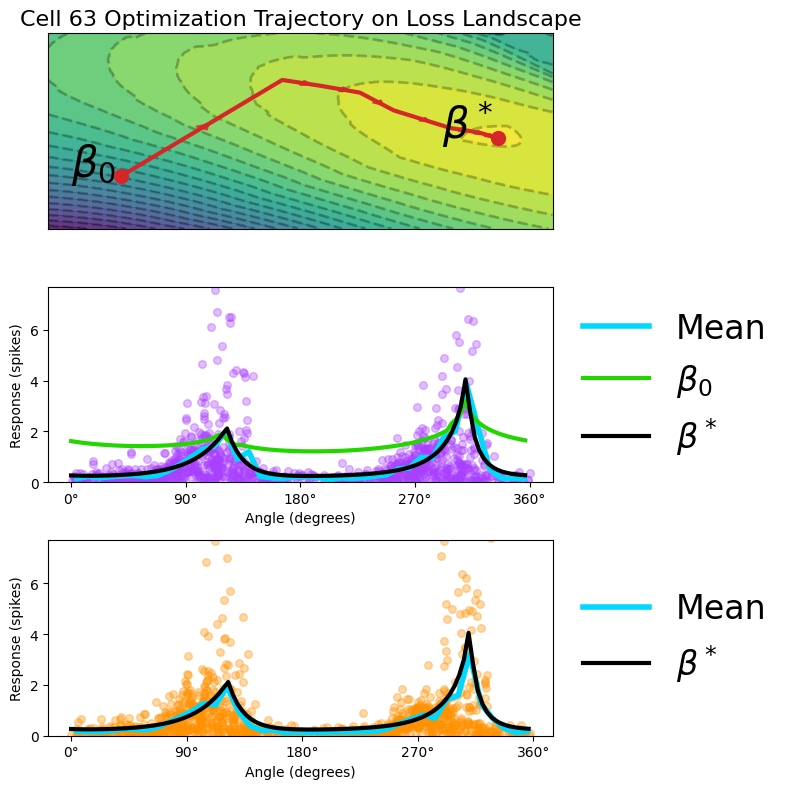

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select a single cell for optimization
cell_index = np.random.randint(0, len(angles))  # Randomly select a cell index for training
# cell_index = 161
# cell_index = 439
# cell_index = 108
# cell_index = 562
# cell_index = 1384
print(f"Training on cell {cell_index} of {len(angles)} cells.")
params_init_single = parameter_estimator(angles[cell_index], response[cell_index])
# params_init_single = jnp.asarray(np.random.uniform(low=0.0, high=1.0, size=(11,)))  # Random initialization for testing
# generate random subsets of n_trials_small
prng = np.random.RandomState(42)  # Fixed seed for reproducibility
training_trials = prng.choice(np.arange(n_trials_small), size=n_trials_small // 2, replace=False)
test_trials = np.setdiff1d(np.arange(n_trials_small), training_trials)
# training_trials = np.arange(n_trials_small // 2)  # Use first half for training
# test_trials = np.arange(n_trials_small // 2, n_trials_small)  # Use second half for testing
angles_train_single = angles[cell_index][training_trials]
response_train_single = response[cell_index][training_trials]
# get test angles and responses for the single cell
angles_test_single = angles[cell_index][test_trials]
response_test_single = response[cell_index][test_trials]

# Define the loss function for a single cell
loss_single_cell = lambda params, x_data, y_data: jnp.mean(
    loss_functions.quadratic_loss(neuron_model(x_data, *params), y_data), axis=-1
)
loss_param_single = lambda params: loss_single_cell(params, angles_train_single, response_train_single)
loss_param_single = jax.jit(loss_param_single)  # JIT compile for performance
loss_param_and_grad_single = jax.value_and_grad(loss_param_single)

# Initialize the optimizer for a single cell
# ------------------------------------------------------------------
# 2.  build the Adam optimiser -------------------------------------
learning_rate = 3e-3       # good default; tune if needed
beta1, beta2  = 0.9, 0.999    # the usual Adam constants

opt = optax.adam(learning_rate, b1=beta1, b2=beta2, eps=1e-8)
opt_state = opt.init(params_init_single.reshape(-1))  # Flatten params for the optimizer

@jax.jit
def train_step(params, opt_state):
    loss, grad = loss_param_and_grad_single(params)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# ------------------------------------------------------------------
# 3.  iterate -------------------------------------------------------
num_steps =  1_000            # or stop on validation patience
print_every = 100  # Print loss every N steps
params_dynamic = [params_init_single.copy()]  # Store parameters at each step for analysis
loss_dynamic = [loss_param_single(params_init_single.copy())]  # Store loss values for analysis

params = params_init_single.copy()  # Initialize parameters for the single cell
best_params = params_init_single.copy()  # Keep track of the best parameters
best_loss = float('inf')  # Initialize best loss to infinity
for step in range(1, num_steps + 1):
    params, opt_state, loss_val = train_step(params, opt_state)
    if step % print_every == 0:
        # print(f"step {step:4d}  loss {loss_val:.4f}")
        params_dynamic.append(params.copy())  # Store parameters at this step
        loss_dynamic.append(loss_val)  # Store loss value at this step
    if loss_val < best_loss:
        best_loss = loss_val
        best_params = params.copy()

# Convert best parameters to a numpy array for easier handling
params_dynamic = jnp.array(params_dynamic)
loss_dynamic = jnp.array(loss_dynamic)

# visualize the results by dimensionality reduction
X = params_dynamic
loss_fn = lambda x: loss_param_single(x)

# --- 1) Standardize ---
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# --- 2) PCA to 2D ---
pca = PCA(n_components=2).fit(X_scaled)
X2 = pca.transform(X_scaled)
if X2[-1, 0] < X2[0, 0]:  # Ensure the trajectory is in the correct direction
    X2[:, 0] *= -1  # Flip the first component to match the original direction

# --- 3) Build a grid in PC‐space ---
pad = 1.0  # extra margin
x0_min, x0_max = X2[:,0].min()-pad, X2[:,0].max()+pad
x1_min, x1_max = X2[:,1].min()-pad, X2[:,1].max()+pad
n_grid = 100
xx, yy = np.meshgrid(
    np.linspace(1.1*x0_min, 1.1*x0_max, n_grid),
    np.linspace(1.5*x1_min, 1.5*x1_max, n_grid),
)
grid_2d = np.vstack([xx.ravel(), yy.ravel()]).T

# --- 4) Reconstruct back and evaluate loss ---
# back to standardized space
grid_orig_scaled = pca.inverse_transform(grid_2d)
# back to original parameter scales
grid_orig = scaler.inverse_transform(grid_orig_scaled)

# vectorized evaluation (might be slow if loss_fn is heavy)
Z = np.array([loss_fn(pt) for pt in grid_orig]).reshape(xx.shape)

# --- 5) Plot contours + trajectory ---
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
cs = plt.contourf(xx, yy, -Z, levels=25, cmap="viridis", alpha=0.85)
plt.contour(xx, yy, -Z, levels=25, colors="black", linewidths=2, alpha=0.25, linestyles="--")
plt.plot(X2[:,0], X2[:,1], "-", color="tab:red", markersize=4, linewidth=3)
# add arrows to indicate the direction of optimization
first_dx = X2[1, 0] - X2[0, 0]
first_dy = X2[1, 1] - X2[0, 1]
first_length = np.sqrt(first_dx**2 + first_dy**2)
n_iter = len(X2)
for i in range(1, n_iter):
    dx = (X2[i, 0] - X2[i-1, 0]) * 0.5
    dy = (X2[i, 1] - X2[i-1, 1]) * 0.5
    current_length = np.sqrt(dx**2 + dy**2)
    plt.arrow(X2[i-1, 0], X2[i-1, 1], dx, dy,
            #   head_width=0.25 * (current_length / first_length) ** 0.5, 
            #   head_length=0.25 * (current_length / first_length) ** 0.5, 
                head_width=0.4 * (i+1) ** (-0.25),
                head_length=0.4 * (i+1) ** (-0.25),
              fc='tab:red', ec='tab:red', alpha=0.8, linewidth=1)
# add dots for begining and end of the trajectory
plt.scatter(X2[0, 0], X2[0, 1], color='tab:red', s=100, label='Start', zorder=5)
plt.scatter(X2[-1, 0], X2[-1, 1], color='tab:red', s=100, label='End', zorder=5)
# on each axis, label the first 3 largest components along with the parameter names
axis_labels = ['PC1 = ', 'PC2 = ']
param_names = np.array(param_names)
param_names_math = [r'$\mathbf{\theta_1}$', r'$\mathbf{b}$', r'$\mathbf{A_1}$', r'$\mathbf{\sigma_{1 \text{+}}}$', 
                    r'$\mathbf{\sigma_{1-}}$', r'$\mathbf{p_1}$', r'$\mathbf{\theta_2}$', r'$\mathbf{A_2}$', 
                    r'$\mathbf{\sigma_{2 \text{+}}}$', r'$\mathbf{\sigma_{2-}}$', r'$\mathbf{p_2}$']
for i in range(2):
    idxs = np.argsort(np.abs(pca.components_[i]))[::-1][:3]
    for j, idx in enumerate(idxs):
        axis_labels[i] += f"{pca.components_[i, idx]:.2f} {param_names_math[idx]}" if j == 0 else f"+ {pca.components_[i, idx]:.2f} {param_names_math[idx]}"
    axis_labels[i] += ' + ...'
# plt.xlabel(axis_labels[0], fontsize=12)
# plt.ylabel(axis_labels[1], fontsize=12)
plt.xticks([])
plt.yticks([])
# add text annotation to the first point
plt.text(X2[0, 0] - 0.1, X2[0, 1], r'$\beta_0$', 
         fontsize=30, ha='right', color='k')
plt.text(X2[-1, 0] - 0.1, X2[-1, 1], r'$\beta^*$',
         fontsize=30, ha='right', color='k')
plt.title(f"Cell {cell_index} Optimization Trajectory on Loss Landscape", fontsize=16)

# plot the function at the initial parameters
x_vals = np.linspace(0, 2 * np.pi, 100, endpoint=False)
x_vals_bin = np.linspace(0, 2 * np.pi, 40, endpoint=False)
binned_means, _ = np.histogram(angles_train_single, bins=x_vals_bin, weights=response_train_single)
binned_means = binned_means / np.histogram(angles_train_single, bins=x_vals_bin)[0]  # Normalize by counts
# repeat the final bin to close the circle
binned_means = np.concatenate((binned_means, [binned_means[0]]))
y_vals = neuron_model(x_vals, *params_init_single)
y_vals_best = neuron_model(x_vals, *best_params)

plt.subplot(3, 1, 2)
plt.scatter(angles_train_single, response_train_single, color="#a93fff", s=30, alpha=0.35)
plt.plot(x_vals_bin + 0.5 * (2 * np.pi / 40),
         binned_means, label='Mean', color="#00d9ff", linewidth=4)
plt.plot(x_vals, y_vals, label=r'$\beta_0$', color="#24d600ff", linewidth=3)
plt.plot(x_vals, y_vals_best, label=r'$\beta^*$', color='k', linewidth=3)
# add xticks every 90 degrees
plt.xticks(np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2),
           [f"{int(np.degrees(angle))}°" for angle in np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2)])
plt.xlabel('Angle (degrees)')
plt.ylabel('Response (spikes)')
# add legend outside the plot, to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24, frameon=False)
plt.ylim(0, binned_means.max() * 2.0)


# plt.subplot(3, 2, 4)
# y_vals_best = neuron_model(x_vals, *best_params)
# plt.scatter(angles_train_single, response_train_single, label='Data', color="#a93fff", s=75, alpha=0.5)
# plt.plot(x_vals_bin, binned_means, label='Mean', color="#00d9ff", linewidth=4)
# plt.plot(x_vals, y_vals_best, label=r'$\beta^*$', color='k', linewidth=4, alpha=0.9)
# plt.legend(loc='upper right', fontsize=15)
# # add xticks every 90 degrees
# plt.xticks(np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2),
#            [f"{int(np.degrees(angle))}°" for angle in np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2)])
# plt.xlabel('Angle (degrees)')
# plt.ylim(0, binned_means.max() * 2.0)

# generate binned means for the test data
binned_means_test, _ = np.histogram(angles_test_single, bins=x_vals_bin, weights=response_test_single)
binned_means_test = binned_means_test / np.histogram(angles_test_single, bins=x_vals_bin)[0]  # Normalize by counts
# repeat the final bin to close the circle
binned_means_test = np.concatenate((binned_means_test, [binned_means_test[0]]))
plt.subplot(3, 1, 3)
plt.scatter(angles_test_single, response_test_single, color="#ff9100", s=30, alpha=0.35)
plt.plot(x_vals_bin + 0.5 * (2 * np.pi / 40),
         binned_means_test, label='Mean', color="#00d9ff", linewidth=4)
plt.plot(x_vals, y_vals_best, label=r'$\beta^*$', color='k', linewidth=3)
# add xticks every 90 degrees
plt.xticks(np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2),
           [f"{int(np.degrees(angle))}°" for angle in np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2)])
plt.xlabel('Angle (degrees)')
plt.ylabel('Response (spikes)')
# plt.title('Test Data Response', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24, frameon=False)
plt.ylim(0, binned_means.max() * 2.0)
plt.tight_layout()
plt.show()


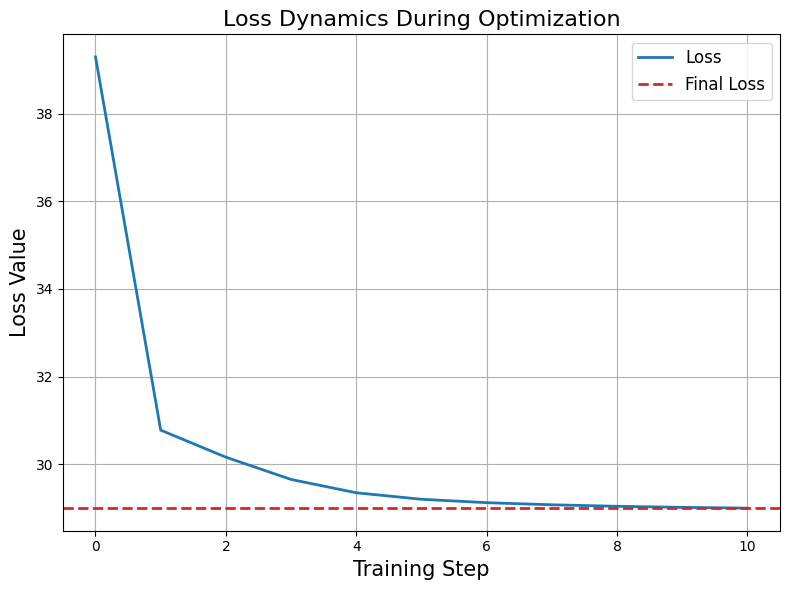

In [ ]:
# # plot the best params
# y_vals_best = neuron_model_numpy(x_vals, *best_params)
# predictions = neuron_model_numpy(angles_single, *best_params)
# loss_vals = 10*abs(predictions - response_single)**0.4
# plt.scatter(angles_single, response_single, s=50, alpha=1, c=loss_vals, cmap='viridis')
# plt.plot(x_vals, y_vals_best, label=r'$\beta_*$', color='tab:red', linewidth=6, alpha=1.0)
# # plt.legend(loc='upper right', fontsize=12)
# # add xticks every 90 degrees
# plt.xticks(np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2),
#            [f"{int(np.degrees(angle))}°" for angle in np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2)], fontsize=15)
# plt.xlabel('Angle (degrees)', fontsize=15)
# plt.ylim(0, 10)
# plt.colorbar(label='Loss (scaled)', orientation='vertical', pad=0.02, aspect=10)
# plt.yticks([])
# plt.ylabel('Response (spikes)', fontsize=15)
# plt.tight_layout()
# plt.show()

# add a plot that shows how the loss is computed
plt.figure(figsize=(8, 6))
plt.plot(loss_dynamic, label='Loss', color='tab:blue', linewidth=2)
plt.axhline(y=loss_dynamic[-1], color='tab:red', linestyle='--', label='Final Loss', linewidth=2)
plt.xlabel('Training Step', fontsize=15)
plt.ylabel('Loss Value', fontsize=15)
plt.title('Loss Dynamics During Optimization', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
# add something to show that we ad
plt.show()


In [48]:
# ----------------------------------------------------------------------
# 0.  Checkpoints (unchanged) + basis  u1, u2  (unchanged)
# ----------------------------------------------------------------------
theta0 = default_params.copy()  # default parameters
theta1 = params_init_single.copy()
theta2 = best_params.copy()

v1 = theta1 - theta0
u1 = v1 / np.linalg.norm(v1)

v2_perp = (theta2 - theta0) - u1 * np.dot(theta2 - theta0, u1)
if np.allclose(v2_perp, 0):
    raise ValueError("θ0, θ1, θ2 are (almost) colinear")
u2 = v2_perp / np.linalg.norm(v2_perp)

# ----------------------------------------------------------------------
# 1.  Choose different pixel counts in X and Y, fix  h  via θ0 → θ1
# ----------------------------------------------------------------------
n_pixels_x = 200       # columns  (horizontal resolution)
n_pixels_y = 100       # rows     (vertical   resolution)

x0_pix, y0_pix = 30, 20
x1_target = n_pixels_x - 30               # keep the same 20-pixel margin
h = np.linalg.norm(theta1 - theta0) / (x1_target - x0_pix)

# ----------------------------------------------------------------------
# 2.  Build the rectangular grid
# ----------------------------------------------------------------------
pix_x = np.arange(n_pixels_x)             # 0 … n_pixels_x-1
pix_y = np.arange(n_pixels_y)             # 0 … n_pixels_y-1
Xpix, Ypix = np.meshgrid(pix_x, pix_y, indexing='xy')   # shapes (ny, nx)

delta = ((Xpix - x0_pix)[..., None] * u1 +
         (Ypix - y0_pix)[..., None] * u2)               # (ny, nx, D)

thetas = theta0 + h * delta
loss_param_subset = lambda t: jnp.mean(loss_total(t.reshape(len(cells), -1), angles_train[cells], response_train[cells]))
loss_param_subset = jax.jit(loss_param_subset)  # JIT compile the loss function for performance
loss_flat = np.array([loss_param_subset(t) for t in thetas.reshape(-1, thetas.shape[-1])])  # (n_pixels_x * n_pixels_y, n_cells)
losses = loss_flat.reshape(n_pixels_y, n_pixels_x)  # (ny, nx)

# ----------------------------------------------------------------------
# 3.  Pixel coordinates of θ1 and θ2 (unchanged math)
# ----------------------------------------------------------------------
def to_pixel(theta):
    d = theta - theta0
    x = np.dot(d, u1) / h + x0_pix
    y = np.dot(d, u2) / h + y0_pix
    return x, y

x1_pix, y1_pix = to_pixel(theta1)          # should be ≈ (x1_target, 20)
x2_pix, y2_pix = to_pixel(theta2)

# ----------------------------------------------------------------------
# 4.  Plot  (losses is now ny×nx)
# ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(16, 10))

im = ax.imshow(losses,
               origin='lower',
               interpolation='nearest',
               cmap='viridis',
               aspect='equal')            # one pixel == one h in either dir

cs = ax.contour(losses, levels=20, colors='k', linewidths=0.7)
ax.clabel(cs, fmt='%.2f', fontsize=6)

colours = ['blue', 'orange', 'red']
i = 0
for x, y, label in [(x0_pix, y0_pix, r'$\theta_{default}$'),
                    (x1_pix, y1_pix, r'$\hat\theta$'),
                    (x2_pix, y2_pix, r'$\theta_{*}$')]:
    ax.plot(x, y, marker='o', markersize=10, color=colours[i])
    ax.text(x + 3, y + 3, label, color=colours[i], fontsize=30)
    i += 1

# plot arrows from θ0 to θ2 and θ1 to θ2. end arrow slightly before the pixel
arrow_length = h
ax.arrow(x0_pix, y0_pix, x2_pix - x0_pix, y2_pix - y0_pix,
         head_width=2.5, head_length=2.5, fc=colours[0], ec=colours[0], length_includes_head=True, linewidth=2)
ax.arrow(x1_pix, y1_pix, x2_pix - x1_pix, y2_pix - y1_pix,
         head_width=2.5, head_length=2.5, fc=colours[1], ec=colours[1], length_includes_head=True, linewidth=2)
# specify which variables axis 1 and axis 2 correspond to
u1_biggest_indices = np.argsort(np.abs(u1))[::-1][:3]  # indices of the two largest components of u1
u2_biggest_indices = np.argsort(np.abs(u2))[::-1][:3]  # indices of the two largest components of u2
u1_vals = u1[u1_biggest_indices]
u2_vals = u2[u2_biggest_indices]
# write ax1 title as f'axis 1 = {u1_vals[0]:.2f} * parma_names[u1_biggest_indices[0]] + {u1_vals[1]:.2f} * {param_names[u1_biggest_indices[1]]} + ...'
ax.set_xlabel('axis 1 = ' + ''.join([f'{u1_vals[i]:.2f} * {param_names[u1_biggest_indices[i]]} + ' for i in range(2)]) + f'\n{u1_vals[2]:.2f} * {param_names[u1_biggest_indices[2]]} + ...', fontsize=15)
ax.set_ylabel('axis 2 = ' + ''.join([f'{u2_vals[i]:.2f} * {param_names[u2_biggest_indices[i]]} + ' for i in range(2)]) + f'\n{u2_vals[2]:.2f} * {param_names[u2_biggest_indices[2]]} + ...', fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f'planar section of loss landscape (cell 124)', fontsize=30)
# fig.colorbar(im, label='Loss', shrink=0.5, aspect=20)
plt.tight_layout()
plt.show()


NameError: name 'loss_total' is not defined

In [ ]:
plt.figure(figsize=(8, 12))
plt.scatter(theta, response, label='data', color='black', alpha=1)
theta_range = np.linspace(0, 2 * np.pi, 100)
plt.plot(theta_range, neuron_model(theta_range, theta_pref_est, baseline_est, amp1_est, amp2_est, width_est),
         label='model fit', color='blue', linewidth=2)
plt.xlim(0, 2 * np.pi)
plt.xticks([theta_pref_est], [f'{theta_pref_est * 180 / np.pi :.2f}°'], fontsize=16)
# plot lines to show how theta_pref, amp, and baseline are estimated
plt.axvline(theta_pref_est, color='red', linestyle='--', label='argmax', linewidth=2)
plt.axhline(np.min(response), color='green', linestyle='--', label='min & max', linewidth=2)
plt.axhline(np.max(response), color='green', linestyle='--', linewidth=2)

# # plot amp as the difference between the max and min of the response
# plt.plot([theta[np.argmax(response)] + np.pi / 2, theta[np.argmax(response)] + np.pi / 2],
#          [baseline_est, baseline_est + amp_est], color='orange', linestyle='--',
#          label='max - min', linewidth=2)

# # add arrows at the top and bottom of the orange line
# plt.annotate('', xy=(theta[np.argmax(response)] + np.pi / 2, baseline_est + amp_est), 
#              xytext=(theta[np.argmax(response)] + np.pi / 2, baseline_est),
#              arrowprops=dict(arrowstyle='<->', color='orange', linewidth=3))

# plt.ylim(0, 1.5)
# plt.yticks([baseline_est, baseline_est + amp_est],
#               [f'{baseline_est:.2f}', f'{baseline_est + amp_est:.2f}'], fontsize=16)
# plt.legend(loc='upper right', fontsize=16)

# plt.xlabel(r'$\theta$', fontsize=24)
# plt.title(f'Neuron Model Example\n\n'
#           r'$\theta_{{pref}}$' +f' = {theta_pref_est * 180 / np.pi:.2f}°, amp = {amp_est:.2f}, baseline = {baseline_est:.2f} \n', fontsize=20)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(theta[: n_data_points // 2], response[: n_data_points // 2], color='tab:green', s=100, label='training trials')
# plt.plot(theta_range, neuron_model(theta_range, theta_pref_est, amp_est, baseline_est), color='blue', linewidth=2, label='model')
plt.plot(theta_range, neuron_model(theta_range, theta_pref_est, amp_est, baseline_est), color='blue', linewidth=3, label='initial params')
# plot lines from each data point to the fitted model
for i in range(n_data_points // 2):
    plt.plot([theta[i], theta[i]], [response[i], neuron_model(theta[i], theta_pref_est, amp_est, baseline_est)], color='gray', alpha=1)
plt.xticks([])
plt.yticks([])
plt.ylim(0.1, 1.3)
plt.legend(loc='upper right', fontsize=16)
plt.xlabel(r'$\theta$', fontsize=24)


In [ ]:
# plot loss as we interpolate between param vectors a and b
def compute_interpolated_loss(a, b, n_points=100, cell_index=0):
    t = np.linspace(0, 1, n_points)
    interpolated_params = a + t[:, None] * (b - a)  # (n_points, n_params)
    losses = np.array([jnp.mean(loss_total(params.reshape(1, -1), angles_train[cell_index:cell_index+1], response_train[cell_index:cell_index+1])) for params in interpolated_params])
    return t, losses

theta_interp, losses_interp = compute_interpolated_loss(theta1, theta2, n_points=100, cell_index=124)
a = r'$\hat\theta$'
b = r'$\theta_{*}$'
plt.figure(figsize=(10, 6))
plt.plot(theta_interp, losses_interp, color='orange', linewidth=2)
plt.axvline(x=0, color='orange', linestyle='--', label=a, linewidth=2)
plt.axvline(x=1, color='red', linestyle='--', label=b, linewidth=2)
plt.xlabel(f'interpolated parameters', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.ylim(30.4, 32.1)
plt.yticks([30.5, 31.0, 31.5, 32.0],)
plt.xticks([0, 0.25, 0.5, 0.75, 1],
           [a,
            rf'$\frac{{3}}{{4}}{a.strip("$")} + \frac{{1}}{{4}}{b.strip("$")}$',
            rf'$\frac{{1}}{{2}}{a.strip("$")} + \frac{{1}}{{2}}{b.strip("$")}$',
            rf'$\frac{{1}}{{4}}{a.strip("$")} + \frac{{3}}{{4}}{b.strip("$")}$',
            b], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Loss slice along ' + a + ' → ' + b, fontsize=25)
plt.legend(loc='upper right', fontsize=15)
plt.show()




In [ ]:
def plot_param_violin_grid(params: np.ndarray,
                           param_names: list[str],
                           labels: tuple[str, str] = ("Initial", "Final"),
                           super_title: str = "Parameter Estimates: Initial vs Final",
                           save_path: str | None = None):
    """
    Show or save an n×n grid of violin-plot pairs (“init” vs “final”)
    for each fitted parameter.

    Parameters
    ----------
    params         : list of m arrays of shape (N, P)
        • Each array corresponds to a set of parameter estimates.
        • Each array must have shape (N, P) where N is the number of samples and P is the number of parameters.
    super_title    : str, optional
        Title for the entire figure.
    labels         : tuple of length m, labels for each param estimate
    param_names    : length-P sequence of str
        Labels for the sub-plots (must match column order).
    save_path      : str or None, optional
        • If None (default) → call plt.show().
        • If a path → save the figure there and return silently.
    """
    # ─── Basic validation ──────────────────────────────────────────────────────
    if not isinstance(params, list) or len(params) < 2:
        raise ValueError("params must be a list with at least two arrays (init and final).")

    n_params = params[0].shape[1]
    n_estimates = len(params)

    # ─── Grid size: n = floor(sqrt(P)), bump if too small ─────────────────────
    n = int(np.floor(np.sqrt(n_params)))
    if n * n < n_params:
        n += 1          # ensure enough panes

    fig, axes = plt.subplots(n, n, figsize=(3 * n, 3 * n))
    axes = axes.flatten()    # flatten for 1-D indexing

    # ─── Draw each violin pair ────────────────────────────────────────────────
    for i in range(n_params):
        ax = axes[i]
        x_vals = np.arange(n_estimates)
        ax.violinplot(
            [params[j][:, i] for j in range(n_estimates)],
            positions=x_vals,
            showmeans=False,
            showmedians=True,
            showextrema=False
        )
        for j in range(n_estimates):
            ax.scatter(
                np.random.normal(x_vals[j], 0.05, size=len(params[j][:, i])),
                params[j][:, i],
                alpha=0.25,
                s=10,
                label=labels[j] if i == 0 else None
            )
        ax.set_xticks(x_vals)
        ax.set_xticklabels(labels, fontsize=10)
        ax.set_title(param_names[i], fontsize=10)
        ax.tick_params(axis='y', labelsize=8)

    # ─── Remove unused sub-plots ───────────────────────────────────────────────
    for j in range(n_params, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.suptitle(super_title, fontsize=16, y=1.02)

    # ─── Save or show ─────────────────────────────────────────────────────────
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

In [ ]:
plot_param_violin_grid(
    params=[params_init, params1, params],
    labels=('initial_guess', 'lbfgs', 'adam'),
    super_title="Parameter Estimates: initial guess, lbfgs (raw) and adam",
    param_names=[
        'theta_pref_1', 'baseline', 'amplitude_1', 'width_ccw_1', 'width_cw_1', 'exponent_1',
        'theta_pref_2', 'amplitude_2', 'width_ccw_2', 'width_cw_2', 'exponent_2'
    ],
)

In [ ]:
import matplotlib.colors as mcolors
from matplotlib import colormaps

def plot_param_scatter_grid(initial_params,
                            final_params,
                            param_names,
                            loss_initial,
                            loss_final,
                            super_title: str = "",
                            save_path: str | None = None):
    """
    Scatter-grid of parameter changes, coloured by Δloss.

    Parameters
    ----------
    initial_params : (N, P) array-like
        Per-cell parameter values *before* optimisation.
    final_params   : (N, P) array-like
        Per-cell parameter values *after* optimisation.
    param_names    : length-P sequence of str
        Titles for each subplot; order must match the parameter columns.
    loss_initial   : length-N array-like
        Loss (or any scalar score) *before* optimisation.
    loss_final     : length-N array-like
        Loss after optimisation.
    save_path      : str or None, optional
        • If None (default) → show the figure interactively.
        • If a path  → save the figure there (PNG, PDF, …) and close it.
    """
    init = np.asarray(initial_params)
    fin  = np.asarray(final_params)
    li   = np.asarray(loss_initial)
    lf   = np.asarray(loss_final)

    # ── Basic validation ──────────────────────────────────────────────────────
    if init.shape != fin.shape:
        raise ValueError("initial_params and final_params must have identical shapes")
    if init.shape[0] != li.size or li.shape != lf.shape:
        raise ValueError("loss vectors must have length equal to the number of rows (cells)")
    if init.shape[1] != len(param_names):
        raise ValueError("param_names length must equal the number of parameters (columns)")

    n_params = init.shape[1]

    # ── Determine grid size: n = ceil(sqrt(P)) ───────────────────────────────
    n = int(np.floor(np.sqrt(n_params)))
    if n * n < n_params:
        n += 1

    fig, axes = plt.subplots(n, n, figsize=(3 * n, 3 * n))
    axes = axes.flatten()

    # ── Colour-map based on Δloss (final − initial) ───────────────────────────
    delta_loss = lf - li
    vmin, vmax = -np.percentile(abs(delta_loss), 90), np.percentile(abs(delta_loss), 90)
    delta_loss = np.clip(delta_loss, vmin, vmax)  # clip to avoid extreme outliers skewing the colour scale
    norm = mcolors.TwoSlopeNorm(vmin=delta_loss.min(),
                                vcenter=0.0,
                                vmax=delta_loss.max())
    cmap = colormaps["coolwarm"]   # modern Matplotlib interface

    # ── Draw scatter for each parameter ───────────────────────────────────────
    for i in range(n_params):
        ax = axes[i]
        ax.scatter(init[:, i], fin[:, i],
                   c=delta_loss,
                   cmap=cmap,
                   norm=norm,
                   s=16,
                   alpha=0.8)
        ax.plot([init[:, i].min(), init[:, i].max()],
                [init[:, i].min(), init[:, i].max()],
                color='black', linestyle='--', linewidth=1.0)
        ax.set_title(param_names[i], fontsize=10)
        ax.set_xlabel("init")
        ax.set_ylabel("final")
        ax.tick_params(labelsize=8)

    # ── Remove any unused subplots ────────────────────────────────────────────
    for j in range(n_params, len(axes)):
        fig.delaxes(axes[j])

    # ── Reserve space for, and add, a shared colour-bar ───────────────────────
    fig.tight_layout(rect=[0, 0, 0.9, 1])          # leave 10 % width on the right
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.6])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Create a dummy array for the colorbar
    sm.set_clim(vmin=vmin, vmax=vmax)  # Set limits for the colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label("Δ loss  (final − initial)")
    plt.suptitle(super_title, fontsize=16, y=1.02)

    # ── Save or show ──────────────────────────────────────────────────────────
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()